<a href="https://colab.research.google.com/github/Asad1287/decision_trees_simulations/blob/main/decision_trees_simulations.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

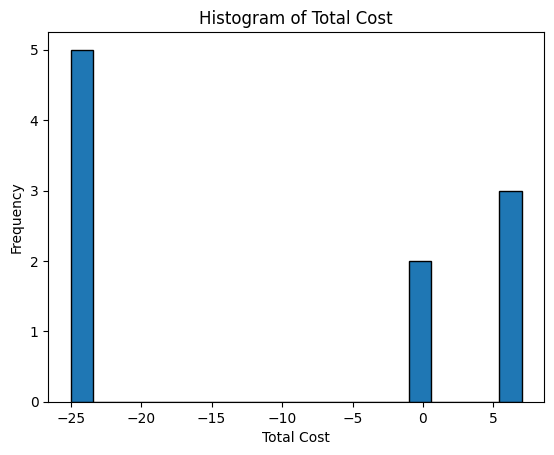

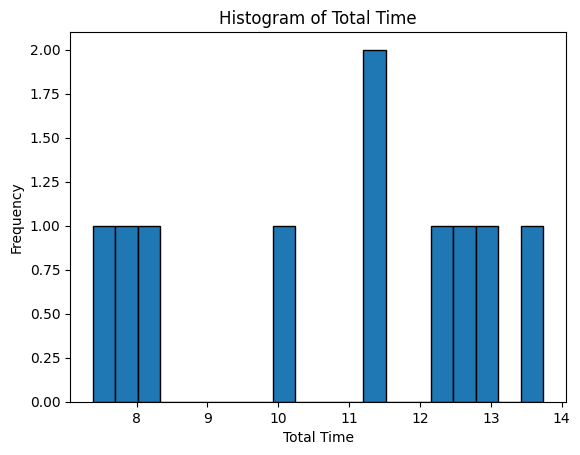

/usr/local/lib/python3.10/dist-packages/scipy/stats/_continuous_distns.py:6111: RuntimeWarning: invalid value encountered in log
  lndata = np.log(data - loc)



Best fit distribution for Total Cost: norm
Distribution parameters: (-10.4, 14.799999999999999)

Best fit distribution for Total Time: weibull_min
Distribution parameters: (28825080.766494058, -50174170.498610735, 50174182.38615967)


In [ ]:
import simpy
import random
from typing import Generator, Type, Dict, List,Union
import yaml
from abc import ABC, abstractmethod
from scipy import stats
import matplotlib.pyplot as plt
import logging
import yaml
class Distribution:
    def __init__(self, dist_type: str, params: Dict[str, float]):
        self.dist_type = dist_type
        self.params = params
        self.dist = getattr(stats, dist_type)(**params)

    def sample(self) -> float:
        return self.dist.rvs()

class Entity(ABC):
    def __init__(self, name: str, arrival_time_dist: Distribution, process_impl: callable) -> None:
        self.name = name
        self.arrival_time_dist = arrival_time_dist
        self.process_impl = process_impl

    def process(self, env: simpy.Environment, resources: Dict[str, 'Resource']) -> Generator:
        yield from self.process_impl(env, self, resources)
class EntityItem:
    def __init__(self, name: str, arrival_time: float) -> None:
        self.name = name
        self.arrival_time = arrival_time
        self.start_times = {}
        self.end_times = {}
        self.costs = {}

class Resource:
    def __init__(self, env: simpy.Environment, capacity: int, service_time_dist: Distribution, cost_dist: Distribution, name: str,children: List['Resource'] = None) -> None:
        self.env = env
        self.resource = simpy.Resource(env, capacity)
        self.service_time_dist = service_time_dist
        self.cost_dist = cost_dist
        self.name = name
        self.queue_lengths = []
        self.children = children if children is not None else []

    def add_child(self, child: 'Resource', probability: float) -> None:
        self.children.append((child, probability))

    def serve(self, entity: EntityItem) -> Generator:
        with self.resource.request() as req:
            self.queue_lengths.append((self.env.now, len(self.resource.queue)))
            yield req
            entity.start_times[self.name] = self.env.now
            logging.info(f"EntityItem {entity.name} starts {self.name} service at {self.env.now:.2f}")
            service_time = self.service_time_dist.sample()
            yield self.env.timeout(service_time)
            entity.end_times[self.name] = self.env.now
            logging.info(f"EntityItem {entity.name} finishes {self.name} service at {self.env.now:.2f}")
            cost = self.cost_dist.sample()
            entity.costs[self.name] = cost
            logging.info(f"Cost for {entity.name} at {self.name}: {cost:.2f}")
class SimulationStop(Exception):
    pass


class StopStage:
    def __init__(self, name: str):
        self.name = name

    def process(self, env: simpy.Environment, entity: EntityItem) -> Generator:
        print(f"Simulation stopped at {env.now:.2f} due to {self.name}")
        raise SimulationStop
class Decision:
    def __init__(self, probabilities: List[float], resources: List[str]):
        self.probabilities = probabilities
        self.resources = resources

    def choose_resource(self) -> str:
        return random.choices(self.resources, self.probabilities)[0]
from collections import deque
class ProcessFlow:
    def __init__(self, env: simpy.Environment, resources: Dict[str, Resource], entry_point: str) -> None:
        self.env = env
        self.resources = resources
        self.entry_point = entry_point

    def probabilistic_selection(self, children):
        nodes, probabilities = zip(*children)
        return random.choices(nodes, weights=probabilities, k=1)[0]

    def process(self, entity: EntityItem) -> Generator:
        yield self.env.timeout(entity.arrival_time)
        logging.info(f"EntityItem {entity.name} enters the system at {self.env.now:.2f}")

        visited = set()
        queue = deque([self.entry_point])
        path = []

        while queue:
            current_resource_name = queue.popleft()
            if current_resource_name not in visited:
                visited.add(current_resource_name)
                path.append(current_resource_name)

                current_resource = self.resources[current_resource_name]
                yield from current_resource.serve(entity)

                if current_resource.children:
                    selected_child = self.probabilistic_selection(current_resource.children)
                    queue.append(selected_child.name)

        logging.info(f"EntityItem {entity.name} leaves the system at {self.env.now:.2f}")
        logging.info(f"Path taken: {' -> '.join(path)}")



class SimulationStats:
    def __init__(self, entities: List[EntityItem], resources: List[Resource]) -> None:
        self.entities = entities
        self.resources = resources

    def calculate_stats(self) -> None:
        waiting_times = {}
        service_times = {}


        for entity in self.entities:
            for resource_name in self.resources:
                if resource_name.name in entity.start_times and resource_name.name in entity.end_times:
                    waiting_time = entity.start_times[resource_name.name] - entity.arrival_time
                    service_time = entity.end_times[resource_name.name] - entity.start_times[resource_name.name]

                    if resource_name.name not in waiting_times:
                        waiting_times[resource_name.name] = []
                        service_times[resource_name.name] = []

                    waiting_times[resource_name.name].append(waiting_time)
                    service_times[resource_name.name].append(service_time)
        total_costs = {}
        for entity in self.entities:
            for resource_name, cost in entity.costs.items():
                if resource_name not in total_costs:
                    total_costs[resource_name] = []
                total_costs[resource_name].append(cost)

        print("\nTotal Costs:")
        for resource_name, costs in total_costs.items():
            total_cost = sum(costs)
            print(f"{resource_name}: {total_cost:.2f}")

        self.plot_total_costs(total_costs)

        print("Average Waiting Times:")
        for resource_name, times in waiting_times.items():
            avg_waiting_time = sum(times) / len(times) if times else 0
            print(f"{resource_name}: {avg_waiting_time:.2f}")

        print("\nAverage Service Times:")
        for resource_name, times in service_times.items():
            avg_service_time = sum(times) / len(times) if times else 0
            print(f"{resource_name}: {avg_service_time:.2f}")

    def plot_queue_lengths(self) -> None:
        for resource in self.resources:
            if resource.queue_lengths:
                times, lengths = zip(*resource.queue_lengths)
                plt.figure()
                plt.plot(times, lengths)
                plt.title(f"Queue Length - {resource.name}")
                plt.xlabel("Simulation Time")
                plt.ylabel("Queue Length")
                plt.show()
            else:
                print(f"No queue length data available for {resource.name}")
    def plot_total_costs(self, total_costs: Dict[str, List[float]]) -> None:
        resources = list(total_costs.keys())
        costs = [sum(costs) for costs in total_costs.values()]
        print(f"total costs is {sum(costs)}")
        plt.figure()
        plt.bar(resources, costs)
        plt.title("Total Costs by Resource")
        plt.xlabel("Resource")
        plt.ylabel("Total Cost")
        plt.show()



class Simulation:
    def __init__(self, num_entities: int, resource_configs: Dict[str, Dict], entry_point: str,
                 entity_class: Type[EntityItem], inter_arrival_time_dist: Distribution,return_plots:bool=False):
        self.num_entities = num_entities
        self.resource_configs = resource_configs
        self.entry_point = entry_point
        self.entity_class = entity_class
        self.inter_arrival_time_dist = inter_arrival_time_dist
        self.entities = []
        self.return_plots = return_plots

    def run_simulation(self) -> simpy.Environment:
        env = simpy.Environment()
        resources = {}

        # Create resources without assigning children
        for resource_name, config in self.resource_configs.items():
            service_time_dist = Distribution(config['service_time_dist'], config['service_time_params'])
            cost_dist = Distribution(config['cost_dist'], config['cost_params'])
            resource = Resource(env, config['capacity'], service_time_dist, cost_dist, resource_name)
            resources[resource_name] = resource

        # Assign children to resources
        for resource_name, config in self.resource_configs.items():
            resource = resources[resource_name]
            for child_name, probability in config.get('children', []):
                child_resource = resources[child_name]
                resource.add_child(child_resource, probability)

        process_flow = ProcessFlow(env, resources, self.entry_point)

        for i in range(self.num_entities):
            arrival_time = self.inter_arrival_time_dist.sample()
            entity = self.entity_class(f"Patient {i+1}", arrival_time)
            self.entities.append(entity)
            env.process(process_flow.process(entity))

        try:
            env.run()
        except SimulationStop:
            print("Simulation stopped.")

        if self.return_plots:
           stats = SimulationStats(self.entities, list(resources.values()))
           stats.calculate_stats()
           stats.plot_queue_lengths()
        return env
class Runner:
    def __init__(self, num_simulations: int, num_patients: int, resource_configs: Dict[str, Dict], entry_point: str,
                 entity_class: Type[EntityItem], inter_arrival_time_dist: Distribution) -> None:
        self.num_simulations = num_simulations
        self.num_patients = num_patients
        self.resource_configs = resource_configs
        self.entry_point = entry_point
        self.entity_class = entity_class
        self.inter_arrival_time_dist = inter_arrival_time_dist

    def run_simulations(self) -> None:
        total_costs = []
        total_times = []

        for i in range(self.num_simulations):
            logging.info(f"Running simulation {i+1}/{self.num_simulations}")
            simulation = Simulation(self.num_patients, self.resource_configs, self.entry_point, self.entity_class, self.inter_arrival_time_dist)
            env = simulation.run_simulation()

            total_cost = sum(sum(entity.costs.values()) for entity in simulation.entities)
            total_time = env.now

            total_costs.append(total_cost)
            total_times.append(total_time)

        self.plot_histogram(total_costs, "Total Cost")
        self.plot_histogram(total_times, "Total Time")

        self.fit_distribution(total_costs, "Total Cost")
        self.fit_distribution(total_times, "Total Time")

    def plot_histogram(self, data: List[float], title: str) -> None:
        plt.figure()
        plt.hist(data, bins=20, edgecolor='black')
        plt.title(f"Histogram of {title}")
        plt.xlabel(title)
        plt.ylabel("Frequency")
        plt.show()

    def fit_distribution(self, data: List[float], title: str) -> None:
        dist_names = ['norm', 'expon', 'gamma', 'lognorm', 'weibull_min', 'weibull_max']
        best_dist = None
        best_params = None
        best_sse = float('inf')

        for dist_name in dist_names:
            dist = getattr(stats, dist_name)
            params = dist.fit(data)
            pdf = dist.pdf(data, *params)
            sse = sum((pdf - data) ** 2)

            if sse < best_sse:
                best_dist = dist
                best_params = params
                best_sse = sse

        print(f"\nBest fit distribution for {title}: {best_dist.name}")
        print(f"Distribution parameters: {best_params}")


def load_resource_config(file_path):
    with open(file_path, 'r') as file:
        config = yaml.safe_load(file)

    resource_configs = {}
    for resource_name, resource_data in config.items():
        children = [(child_name, probability) for child_data in resource_data.get('children', []) for child_name, probability in child_data.items()]
        resource_configs[resource_name] = {
            'capacity': resource_data['capacity'],
            'service_time_dist': resource_data['service_time_dist'],
            'service_time_params': resource_data['service_time_params'],
            'cost_dist': resource_data['cost_dist'],
            'cost_params': resource_data['cost_params'],
            'children': children
        }

    return resource_configs

if __name__ == "__main__":
    num_simulations = 10
    num_entities_per_sim = 1
    file_path = 'simulation.yaml'
    resource_configs = load_resource_config(file_path)

    entry_point = 'start'
    inter_arrival_time_dist = Distribution('uniform', {'loc': 0, 'scale': 5})

    runner = Runner(num_simulations, num_entities_per_sim, resource_configs, entry_point, EntityItem, inter_arrival_time_dist)
    runner.run_simulations()